In [19]:
import socket

simulator_name = 'spiNNaker'


from spynnaker.pyNN import *
import pyNN.spiNNaker as p
from pyNN.random import NumpyRNG, RandomDistribution
from pyNN.utility import Timer

timer = Timer()

# === Define parameters ===
threads = 1
rngseed = 98766987
parallel_safe = True
stim_dur = 50.    # (ms) duration of random stimulation
rate = 100.       # (Hz) frequency of the random stimulation

dt = 1.0          # (ms) simulation timestep
tstop = 1000      # (ms) simulaton duration
delay = 2

In [20]:
n = 500          # number of cells
exc_ratio = 0.8   # ratio of excitatory neurons
pconn = 0.02      # connection probability

n_exc = int(round(n*0.8))
n_inh = n-n_exc
print n_exc, n_inh

# === cell parameters === TODO: 
v_reset = -60.    # (mV)
v_thresh = -50.   # (mV)

Gexc = 4.     # (nS)
Ginh = 51.    # (nS)
w_exc = Gexc * 1e-3              # We convert conductances to uS
w_inh = Ginh * 1e-3
    


400 100


In [21]:
# === setup connection to SpiNNaker ===

extra = {'threads': threads,
         'filename': "Izhikevich_reservoir.xml",
         'label': 'VA'}

node_id = setup(timestep=dt, min_delay=delay, max_delay=delay, db_name='Izhikevich_reservoir.sqlite', **extra)

if simulator_name == 'spiNNaker':
    set_number_of_neurons_per_core('IZK_cond_exp', 50)      # this will set 100 neurons per core

node_id = 1
np = 1

host_name = socket.gethostname()
print "Host #%d is on %s" % (np, host_name)

print "%s Initialising the simulator with %d thread(s)..." % (
    node_id, extra['threads'])

2017-08-30 19:45:41 INFO: sPyNNaker (c) 2016 APT Group, University of Manchester
2017-08-30 19:45:41 INFO: Release version 3.0.0() - September 2016. Installed in folder /usr/local/lib/python2.7/dist-packages
2017-08-30 19:45:41 WARNING: Extra params has been applied to the setup command which we do not consider
2017-08-30 19:45:41 INFO: Will search these locations for binaries: /usr/local/lib/python2.7/dist-packages/spinn_front_end_common/common_model_binaries : /usr/local/lib/python2.7/dist-packages/spynnaker/pyNN/model_binaries : /usr/local/lib/python2.7/dist-packages/spynnaker/pyNN/model_binaries : /usr/local/lib/python2.7/dist-packages/spynnaker/pyNN/model_binaries : /usr/local/lib/python2.7/dist-packages/spynnaker/pyNN/model_binaries
2017-08-30 19:45:41 INFO: Setting appID to 30.
2017-08-30 19:45:41 INFO: Setting time scale factor to 1.
2017-08-30 19:45:41 INFO: Setting machine time step to 1000.0 micro-seconds.


Host #1 is on roboy-server0
1 Initialising the simulator with 1 thread(s)...


In [22]:
# === Build the network ===

celltype = p.IZK_cond_exp
cell_params = {'a':0.02, 'b':0.2, 'c':-65, 'd':6, 'i_offset':0.0}

print "%s Creating cell populations..." % node_id
exc_cells = Population(n_exc, celltype, cell_params, label="Excitatory_Cells")
inh_cells = Population(n_inh, celltype, cell_params, label="Inhibitory_Cells")

print("setting up the spike source")
ext_stim = Population(
            20, SpikeSourcePoisson,
            {'rate': rate, 'duration': stim_dur},
            label="expoisson")
rconn = 0.01
ext_conn = FixedProbabilityConnector(rconn, weights=0.1)
ext_stim.record()

1 Creating cell populations...
setting up the spike source


In [23]:
print "%s Initialising membrane potential to random values..." % node_id

rng = NumpyRNG(seed=rngseed, parallel_safe=parallel_safe)
uniformDistr = RandomDistribution('uniform', [v_reset, v_thresh], rng=rng)
exc_cells.initialize('v', uniformDistr)
inh_cells.initialize('v', uniformDistr)

1 Initialising membrane potential to random values...


In [24]:
print "%s Connecting populations..." % node_id
exc_conn = FixedProbabilityConnector(pconn, weights=w_exc, delays=delay)
inh_conn = FixedProbabilityConnector(pconn, weights=w_inh, delays=delay)

connections = {}
connections['e2e'] = Projection(exc_cells, exc_cells, exc_conn,
                                target='excitatory', rng=rng)
connections['e2i'] = Projection(exc_cells, inh_cells, exc_conn,
                                target='excitatory', rng=rng)
connections['i2e'] = Projection(inh_cells, exc_cells, inh_conn,
                                target='inhibitory', rng=rng)
connections['i2i'] = Projection(inh_cells, inh_cells, inh_conn,
                                target='inhibitory', rng=rng)


connections['ext2e'] = Projection(ext_stim, exc_cells, ext_conn,
                                      target='excitatory')
connections['ext2i'] = Projection(ext_stim, inh_cells, ext_conn,
                                      target='excitatory')


1 Connecting populations...


In [25]:

# === Setup recording ===
print "%s Setting up recording..." % node_id
exc_cells.record()

buildCPUTime = timer.diff()

# === Run simulation ===
print "%d Running simulation..." % node_id

print "timings: number of neurons:", n
print "timings: number of synapses:", n * n * pconn

run(tstop)

simCPUTime = timer.diff()


2017-08-30 19:45:42 INFO: Starting execution process
2017-08-30 19:45:43 INFO: Creating transceiver for 192.168.240.36
2017-08-30 19:45:43 INFO: Working out if machine is booted
2017-08-30 19:45:43 INFO: Found board with version [Version: SC&MP 3.0.1 at SpiNNaker:0:0:0 (built Wed Jul 20 11:07:23 2016)]
2017-08-30 19:45:43 INFO: Machine communication successful
2017-08-30 19:45:43 INFO: Detected a machine on ip address 192.168.240.36 which has 72 cores and 8 links


1 Setting up recording...
1 Running simulation...
timings: number of neurons: 500
timings: number of synapses: 5000.0


2017-08-30 19:45:43 INFO: Time 0:00:00.230078 taken by FrontEndCommonMachineGenerator
Allocating virtual identifiers
|0                           50%                         100%|
2017-08-30 19:45:43 INFO: Time 0:00:00.015220 taken by MallocBasedChipIDAllocator
2017-08-30 19:45:43 INFO: Time 0:00:00.000242 taken by FrontEndCommonApplicationGraphNetworkSpecificationReport
Partitioning graph vertices
|0                           50%                         100%|
Partitioning graph edges
|0                           50%                         100%|
2017-08-30 19:45:43 INFO: Time 0:00:00.102863 taken by PartitionAndPlacePartitioner
Generating partitioner report
|0                           50%                         100%|
2017-08-30 19:45:43 INFO: Time 0:00:00.007251 taken by PartitionerReport
Filtering edges
|0                           50%                         100%|
2017-08-30 19:45:43 INFO: Time 0:00:00.086477 taken by GraphEdgeFilter
Placing graph vertices
|0                      

ValueError: shape mismatch: value array of shape (32,) could not be broadcast to indexing result of shape (0,)

2017-08-30 19:32:41 WARNING: The simulation has not yet run, therefore spikes cannot be retrieved, hence the list will be empty


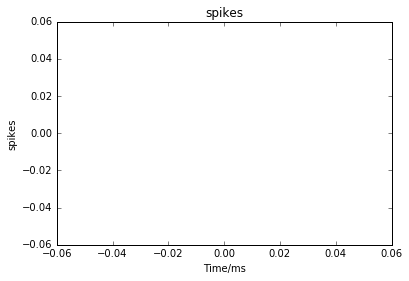

SpinnmanIOException: IO Error: [Errno 9] Bad file descriptor

In [8]:

# === Print results to file ===

import pylab

exc_spikes = exc_cells.getSpikes(compatible_output=True)
pylab.figure()
pylab.plot([i[1] for i in exc_spikes],
           [i[0] for i in exc_spikes], ".", markersize=2)
pylab.xlabel('Time/ms')
pylab.ylabel('spikes')
pylab.title('spikes')
pylab.show()

writeCPUTime = timer.diff()

if node_id == 0:
    print "\n--- Vogels-Abbott Network Simulation ---"
    print "Nodes                  : %d" % np
    print "Simulation type        : %s" % benchmark
    print "Number of Neurons      : %d" % n
    print "Number of Synapses     : %s" % connections
    print "Excitatory conductance : %g nS" % Gexc
    print "Inhibitory conductance : %g nS" % Ginh
    print "Build time             : %g s" % buildCPUTime
    print "Simulation time        : %g s" % simCPUTime
    print "Writing time           : %g s" % writeCPUTime


# === Finished with simulator ===

end()